In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import os
import pandas as pd
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
RANDOM_SEED = 42
K_RECOS = 10
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

DATA_PATH = "data/kion_train"
RESULTS_PATH = "results/hw5"

# Data

In [3]:
interactions_df = pd.read_csv(f'{DATA_PATH}/interactions.csv', parse_dates=["last_watch_dt"])

interactions_df.rename(
    columns={
        "total_dur": "weight", 
        "last_watch_dt": "datetime"
    }, 
    inplace=True) 

users_df = pd.read_csv(f'{DATA_PATH}/users.csv')

items_df = pd.read_csv(f'{DATA_PATH}/items.csv')
items_df = items_df.rename(columns = {'id' : 'item_id'})

# Data proccessing

In [4]:
interactions_df = interactions_df[interactions_df["datetime"] < "2021-04-01"]

In [5]:
users_interactions_count_df = interactions_df.groupby(['user_id', 'item_id']).size().groupby('user_id').size()
print(f'# users: {len(users_interactions_count_df)}')

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['user_id']]
print(f'# users with at least 5 interactions: {len(users_with_enough_interactions_df)}')

# users: 86614
# users with at least 5 interactions: 14563


In [6]:
print(f'# of interactions: {len(interactions_df)}')
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')

print(f'# of interactions from users with at least 5 interactions: {len(interactions_from_selected_users_df)}')

# of interactions: 263874
# of interactions from users with at least 5 interactions: 142670


In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [7]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['user_id', 'item_id'])['watched_pct'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 142670


,user_id,item_id,watched_pct
0,21,849,6.375039
1,21,4345,6.658211
2,21,10283,6.658211
3,21,12261,6.658211
4,21,15997,6.658211
5,32,952,6.044394
6,32,4382,4.954196
7,32,4807,6.658211
8,32,10436,6.658211
9,32,12132,6.658211


In [8]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['user_id'], 
                                   test_size=0.20,
                                   random_state=42)

print(f'# interactions on Train set: {len(interactions_train_df)}')
print(f'# interactions on Test set: {len(interactions_test_df)}')

# interactions on Train set: 114136
# interactions on Test set: 28534


In [9]:
# index by id to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('user_id')
interactions_train_indexed_df = interactions_train_df.set_index('user_id')
interactions_test_indexed_df = interactions_test_df.set_index('user_id')

In [10]:
def get_items_interacted(person_id, interactions):
    # add movie information to the user's data
    interacted_items = interactions.loc[person_id]['item_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [11]:
#Top-N accuracy metrics consts

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['item_id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['item_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['item_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['item_id'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['item_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['item_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(tqdm(list(interactions_test_indexed_df.index.unique().values))):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['user_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [12]:
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [13]:
# Constants
SEED = 42 # random seed for reproducibility
LR = 1e-3 # learning rate, controls the speed of the training
WEIGHT_DECAY = 0.01 # lambda for L2 reg. ()
NUM_EPOCHS = 80 # num training epochs (how many times each instance will be processed)
GAMMA = 0.9995 # learning rate scheduler parameter
BATCH_SIZE = 3000 # training batch size
EVAL_BATCH_SIZE = 3000 # evaluation batch size.
DEVICE = 'cuda' #'cuda' # device to make the calculations on

In [14]:
print(interactions_train_df.shape)
total_df = pd.concat([interactions_train_df, interactions_test_indexed_df.reset_index()], ignore_index=True)
print(total_df.shape)
total_df['user_id'], users_keys = total_df.user_id.factorize()
total_df['item_id'], items_keys = total_df.item_id.factorize()

train_encoded = total_df.iloc[:len(interactions_train_df)].values
test_encoded = total_df.iloc[len(interactions_train_df):].values

(114136, 3)
(142670, 3)


In [15]:
from scipy.sparse import csr_matrix
shape = [int(total_df['user_id'].max()+1), int(total_df['item_id'].max()+1)]
X_train = csr_matrix((train_encoded[:, 2], (train_encoded[:, 0], train_encoded[:, 1])), shape=shape).toarray()
X_test = csr_matrix((test_encoded[:, 2], (test_encoded[:, 0], test_encoded[:, 1])), shape=shape).toarray()

In [16]:
# Initialize the DataObject, which must return an element (features vector x and target value y)
# for a given idx. This class must also have a length atribute
class UserOrientedDataset(Dataset):
    def __init__(self, X):
        super().__init__() # to initialize the parent class
        self.X = X.astype(np.float32)
        self.len = len(X)

    def __len__(self): # We use __func__ for implementing in-built python functions
        return self.len

    def __getitem__(self, index):
        return self.X[index]

In [17]:
# Initialize DataLoaders - objects, which sample instances from DataObject-s
train_dl = DataLoader(
    UserOrientedDataset(X_train),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dl = DataLoader(
    UserOrientedDataset(X_test),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)

dls = {'train': train_dl, 'test': test_dl}

In [18]:
# add linear layer, batch normalization, dropout and change activation function

class Model(nn.Module):
   def __init__(self, in_and_out_features = 8287):
       super().__init__()
       self.in_and_out_features = in_and_out_features
       self.hidden_size = 500

       self.sequential = nn.Sequential( # NN architecture, where the modules modify the data sequentially
           nn.Linear(in_and_out_features, self.hidden_size), # Linear transformation
           nn.BatchNorm1d(self.hidden_size), # Batch normalization
           nn.ELU(), # Activation function
           nn.Dropout(0.5), # Dropout
           nn.Linear(self.hidden_size, self.hidden_size), # Another Linear transformation
           nn.BatchNorm1d(self.hidden_size), # Batch normalization
           nn.ELU(), # Activation function
           nn.Dropout(0.5), # Dropout
           nn.Linear(self.hidden_size, in_and_out_features) # Final Linear transformation
       )

   def forward(self, x): # In the forward function, you define how your model runs, from input to output 
       x = self.sequential(x)
       return x

In [19]:
torch.manual_seed(SEED) # Fix random seed to have reproducible weights of model layers

model = Model()
# model.to(DEVICE)

# Initialize GD method, which will update the weights of the model
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# Initialize learning rate scheduler, which will decrease LR according to some rule
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

def rmse_for_sparse(x_pred, x_true):
    mask = (x_true > 0)
    sq_diff = (x_pred * mask - x_true) ** 2
    mse = sq_diff.sum() / mask.sum()
    return mse ** (1/2)

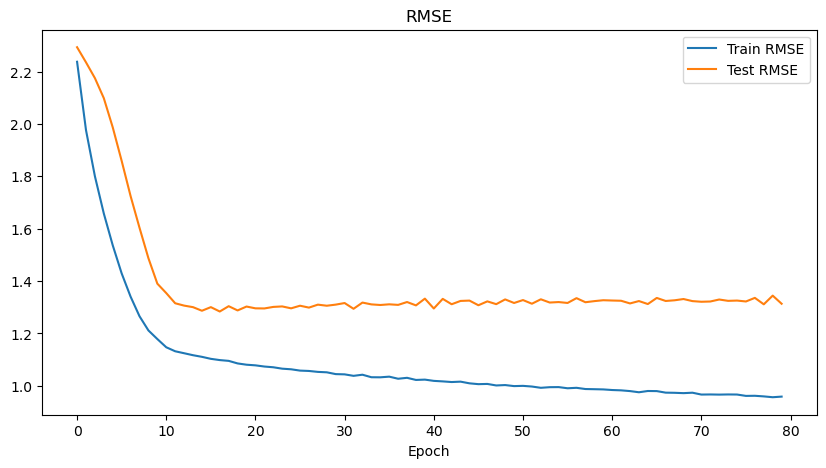

In [20]:
# Training loop
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Test RMSE": [],
}

# Train loop
for epoch in range(NUM_EPOCHS):
    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'test']:
        with torch.set_grad_enabled(stage == 'train'): # Whether to start building a graph for a backward pass
            if stage == 'train':
                model.train() # Enable some "special" layers (will speak about later)
            else:
                model.eval() # Disable some "special" layers (will speak about later)

            loss_at_stage = 0 
            for batch in dls[stage]:
                # batch = batch.to(DEVICE)
                x_pred = model(batch) # forward pass: model(x_batch) -> calls forward()
                loss = rmse_for_sparse(x_pred, batch) # ¡Important! y_pred is always the first arg
                if stage == "train":
                    loss.backward() # Calculate the gradients of all the parameters wrt loss
                    optimizer.step() # Update the parameters
                    scheduler.step()
                    optimizer.zero_grad() # Zero the saved gradient
                loss_at_stage += loss.item() * len(batch)
            rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
            metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)
            
    if (epoch == NUM_EPOCHS - 1) or epoch % 10 == 9:

        clear_output(True)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        ax.set_xlabel('Epoch')
        ax.set_title('RMSE')
        ax.plot(metrics_dict['Train RMSE'], label='Train RMSE')
        ax.plot(metrics_dict['Test RMSE'], label='Test RMSE')
        plt.legend()
        plt.show()

In [21]:
with torch.no_grad():
    X_pred = model(torch.Tensor(X_test))
X_pred

tensor([[ 2.0180,  3.1741,  1.6917,  ...,  0.0063,  0.0337,  0.0807],
        [ 0.3954,  0.7113, -0.1010,  ...,  0.0617,  0.0413, -0.0104],
        [ 0.7686,  1.3392,  0.1276,  ..., -0.3664,  0.0855,  0.0040],
        ...,
        [ 0.4175,  0.9559, -0.1008,  ..., -0.0440,  0.0369,  0.1156],
        [ 0.9847,  1.6261,  0.7060,  ..., -0.0211,  0.0337,  0.3216],
        [ 0.9747,  1.2141,  0.1123,  ...,  0.2412,  0.0246,  0.1788]])

In [22]:
class AERecommender:
    
    MODEL_NAME = 'Autoencoder'
    
    def __init__(self, X_preds, X_train_and_val, X_test):

        self.X_preds = X_preds.cpu().detach().numpy()
        self.X_train_and_val = X_train_and_val
        self.X_test = X_test
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_select_idx, topn=10, verbose=False):
        user_preds = self.X_preds[user_id][items_to_select_idx]
        items_idx = items_to_select_idx[np.argsort(-user_preds)[:topn]]

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        return items_idx

    def evaluate(self, size=100):

        X_total = self.X_train_and_val + self.X_test

        true_5 = []
        true_10 = []

        for user_id in range(len(X_test)):
            non_zero = np.argwhere(self.X_test[user_id] > 0).ravel()
            all_nonzero = np.argwhere(X_total[user_id] > 0).ravel()
            select_from = np.setdiff1d(np.arange(X_total.shape[1]), all_nonzero)

            for non_zero_idx in non_zero:
                random_non_interacted_100_items = np.random.choice(select_from, size=20, replace=False)
                preds = self.recommend_items(user_id, np.append(random_non_interacted_100_items, non_zero_idx), topn=10)
                true_5.append(non_zero_idx in preds[:5])
                true_10.append(non_zero_idx in preds)

        return {"recall@5": np.mean(true_5), "recall@10": np.mean(true_10)}
    
ae_recommender_model = AERecommender(X_pred, X_train, X_train)

In [23]:
ae_global_metrics = ae_recommender_model.evaluate()
ae_global_metrics

{'recall@5': 0.5598018469579803, 'recall@10': 0.8092679454299004}

# Prepare offline predictions

In [24]:
encoded_data = total_df.values

max_user_id = int(total_df["user_id"].max())
max_item_id = int(total_df["item_id"].max())
shape = [max_user_id + 1, max_item_id + 1]

X = np.zeros(shape)
X[encoded_data[:, 0].astype(int), encoded_data[:, 1].astype(int)] = encoded_data[:, 2]

In [25]:
def get_encoder_reco(user_id):
    df_X = pd.DataFrame(X)
    df_X_pred = pd.DataFrame(X_pred.cpu())
    all_nonzero = df_X.iloc[user_id][df_X.iloc[user_id] > 0].index
    select_from = df_X.columns.difference(all_nonzero)
    random_non_interacted_100_items = np.random.choice(select_from, size=20, replace=False)
    user_preds = df_X_pred.iloc[user_id][random_non_interacted_100_items]
    items_idx = random_non_interacted_100_items[np.argsort(-user_preds)[:10]]

    return items_idx

In [26]:
with torch.no_grad():
    X_pred = model(torch.Tensor(torch.Tensor(X)))
X_pred

tensor([[ 6.5484e+00,  4.4617e+00,  2.7910e+00,  ...,  1.7692e-01,
         -4.3477e-01,  1.9816e-01],
        [ 2.4515e+00,  6.4287e+00,  6.0549e-01,  ...,  3.4968e-01,
          5.9464e-03, -4.4737e-01],
        [ 1.4199e+00,  2.1204e+00,  5.0393e+00,  ..., -7.7260e-02,
          7.9661e-03,  4.9700e-01],
        ...,
        [ 5.2789e-01,  9.6225e-01,  5.8671e-02,  ..., -1.3635e-01,
         -4.1320e-02,  5.2761e-02],
        [ 3.1549e+00,  3.0127e+00,  1.2871e+00,  ..., -4.1579e-01,
         -3.5057e-01, -2.3604e-01],
        [ 1.8759e+00,  1.7777e+00,  6.0484e-01,  ...,  4.2430e-01,
          4.5014e-01, -1.1312e-01]])

In [27]:
autoencoder_recs = {}
users_ids = interactions_full_indexed_df.index.unique()
for i, user_id in enumerate(users_ids):
    autoencoder_recs[user_id] = get_encoder_reco(i).tolist()

In [31]:
import dill

with open(f"{RESULTS_PATH}/encoder_recs.dill", "wb") as file:
    dill.dump(autoencoder_recs, file)